# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', ';')

In [17]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [5]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [130]:
# Identify missing or unknown data values and convert them to NaNs.

In [3]:
feat_info.sample(10)

,attribute,information_level,type,missing_or_unknown
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
66,BALLRAUM,postcode,ordinal,[-1]
76,PLZ8_ANTG2,macrocell_plz8,ordinal,[-1]
49,WOHNDAUER_2008,household,ordinal,"[-1,0]"
7,FINANZ_ANLEGER,person,ordinal,[-1]
44,ANZ_PERSONEN,household,numeric,[]
63,KBA05_ANTG4,microcell_rr3,ordinal,[-1]
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
70,KKK,region_rr1,ordinal,"[-1,0]"


In [3]:
azdias_missing = azdias.copy()

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
for i in range(feat_info.shape[0]):
    missing = feat_info.missing_or_unknown.iloc[i]
    attribute_column_name = feat_info.attribute.iloc[i]
    missing = missing[1:-1]
    if(len(missing) == 0):
        azdias_missing[attribute_column_name] = azdias_missing[attribute_column_name].replace(missing,np.nan)
    elif(len(missing) != 0):
        missing = missing.split(',')
        for j in range(len(missing)):
            if(azdias_missing[attribute_column_name].dtype == np.float64):
                azdias_missing[attribute_column_name] = azdias_missing[attribute_column_name].replace(float(missing[j]),np.nan)
            elif(azdias_missing[attribute_column_name].dtype == np.int64):
                azdias_missing[attribute_column_name] = azdias_missing[attribute_column_name].replace(int(missing[j]),np.nan)
            
            else:
                azdias_missing[attribute_column_name] = azdias_missing[attribute_column_name].replace(missing[j],np.nan)


#### Test Scenario for identify missing or unknown data values and convert them to NaNs

In [5]:
azdias_missing.AGER_TYP.value_counts()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

In [122]:
azdias.AGER_TYP.value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [128]:
azdias.AGER_TYP.isna().values.any()

False

In [129]:
azdias_missing.AGER_TYP.isna().values.any()

True

In [6]:
azdias_missing['CAMEO_DEUG_2015'][2511]

nan

In [7]:
azdias['CAMEO_DEUG_2015'][2511]

'X'

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

##### Perform an assessment of how much missing data there is in each column of the dataset.

In [5]:
na_counts = azdias_missing.isna().sum()
na_columns = np.array(na_counts.index.values)
na_counts_np = np.array(na_counts)

In [6]:
missing_data_azdias = pd.DataFrame({'NaN_Counts': na_counts, 'NaN_Proportions(%)': (na_counts / azdias_missing.shape[0]) * 100})
missing_data_azdias = missing_data_azdias.sort_values(by='NaN_Counts', ascending=False)
missing_data_azdias.head(8)

,NaN_Counts,NaN_Proportions(%)
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
KKK,158064,17.735668
REGIOTYP,158064,17.735668


##### Investigate patterns in the amount of missing data in each column.

- Divide Graph into two parts to be more clear

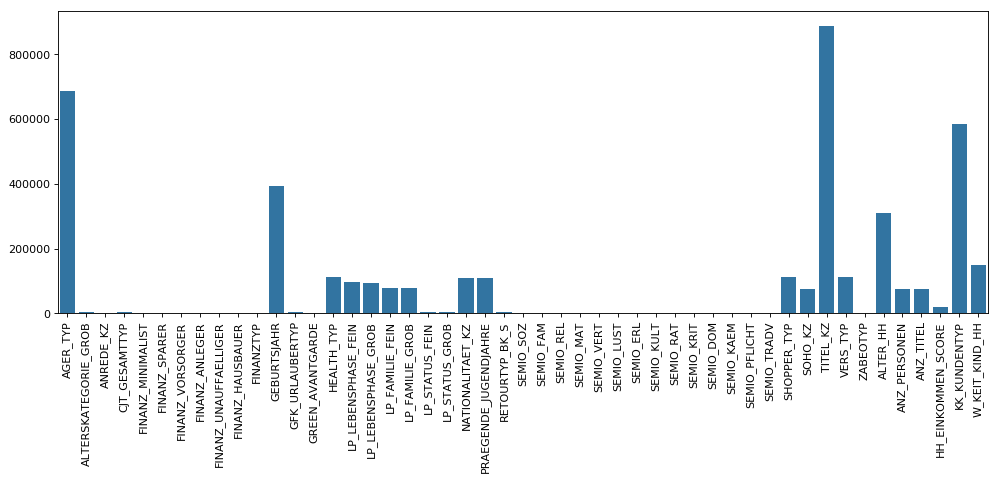

In [19]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
base_color = sb.color_palette()[0]
sb.barplot(na_columns[:49], na_counts_np[:49], color=base_color)
plt.xticks(rotation = 90);

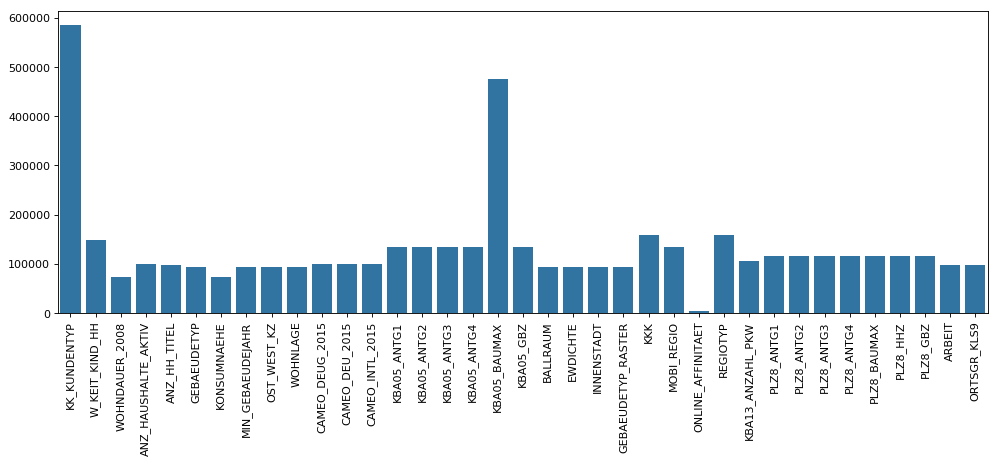

In [20]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
base_color = sb.color_palette()[0]
sb.barplot(na_columns[47:-1], na_counts_np[47:-1], color=base_color)
plt.xticks(rotation = 90);

##### Remove the outlier columns from the dataset.

In [7]:
outlier_columns = ['AGER_TYP', 'KK_KUNDENTYP','TITEL_KZ', 'KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
azdias_missing = azdias_missing.drop(outlier_columns, axis=1)

In [8]:
# Make a copy of feat_info and drop the outlier columns in it also
feat_info_missing = feat_info.copy()
print(feat_info_missing.shape)
feat_info_missing = feat_info_missing[~feat_info_missing.attribute.isin(outlier_columns)]
print(feat_info_missing.shape)

(85, 4)
(79, 4)


#### Discussion 1.1.2: Assess Missing Data in Each Column

- It is observed than most of the columns have missing data for a mean of 11%
- There were 6 columns that had more than 30% missing therefore were dropped as they will not be useful
- Around 28% of columns has no missing values
- The columns with the missing data are of various type (ordinal, categorical, numeric), couldn't observe a clear relationship 
    between them

In [69]:
missing_data_azdias.describe()

,NaN_Counts,NaN_Proportion(%)
count,85.000000,85.000000
mean,98516.811765,11.054139
std,146604.203317,16.449815
min,0.000000,0.000000
25%,0.000000,0.000000
50%,93148.000000,10.451729
75%,116515.000000,13.073637
max,889061.000000,99.757636


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [9]:
# How much data is missing in each row of the dataset?
n_missing_rows = azdias_missing.isna().sum(axis=1)

In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
n_missing_rows_high = n_missing_rows[n_missing_rows > 20]
n_missing_rows_low = n_missing_rows[n_missing_rows < 20]

In [11]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare(column_name):
    figure(figsize=(14,5))
    plt.subplot(1,2,1)
    sb.countplot(data=azdias_missing.iloc[n_missing_rows_high.index], x=column_name, color=sb.color_palette()[0])
    plt.title('High Missing Data')
    
    plt.subplot(1,2,2)
    sb.countplot(data=azdias_missing.iloc[n_missing_rows_low.index], x=column_name, color=sb.color_palette()[1])
    plt.title('Few Missing Data')

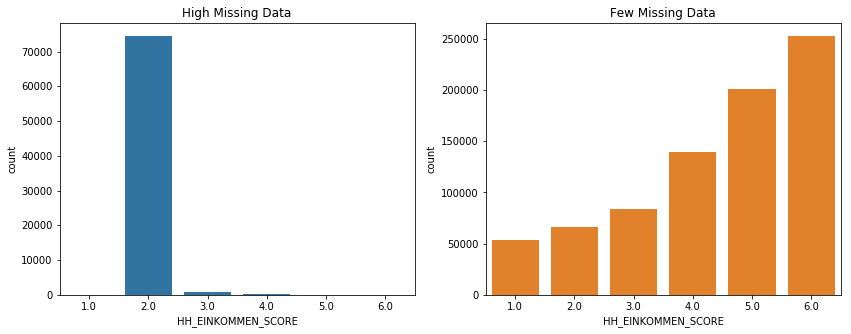

In [12]:
compare('HH_EINKOMMEN_SCORE')

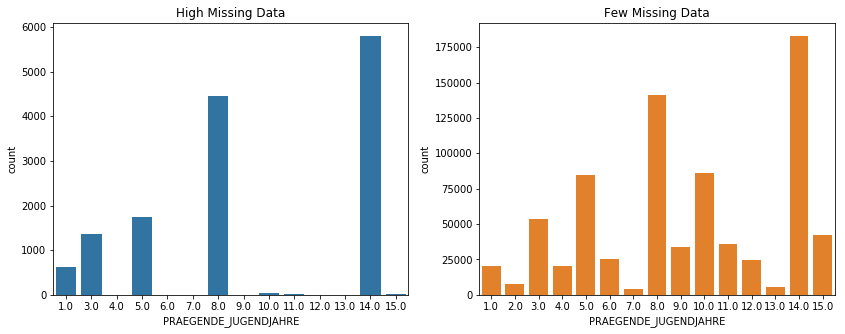

In [204]:
compare('PRAEGENDE_JUGENDJAHRE')

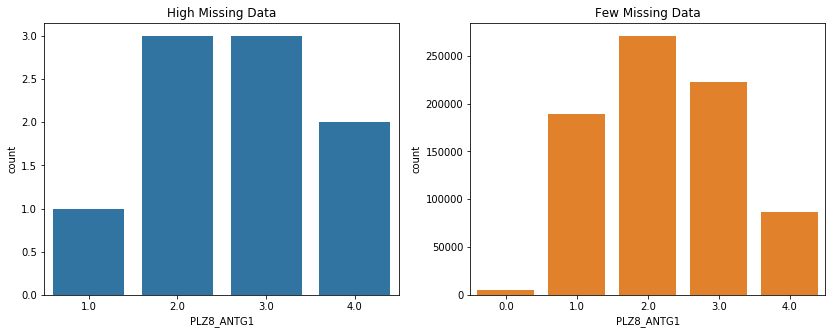

In [205]:
compare('PLZ8_ANTG1') 

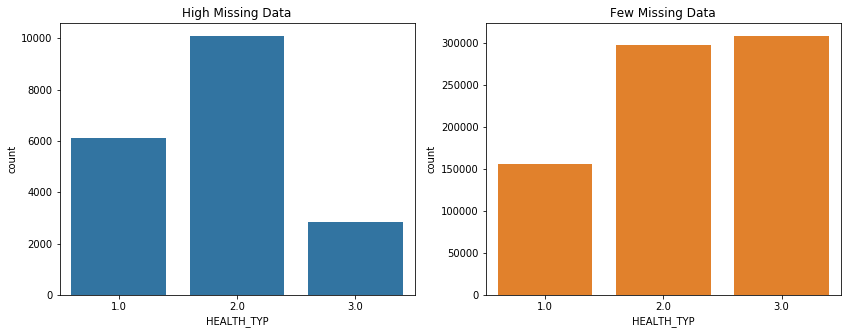

In [206]:
compare('HEALTH_TYP') 

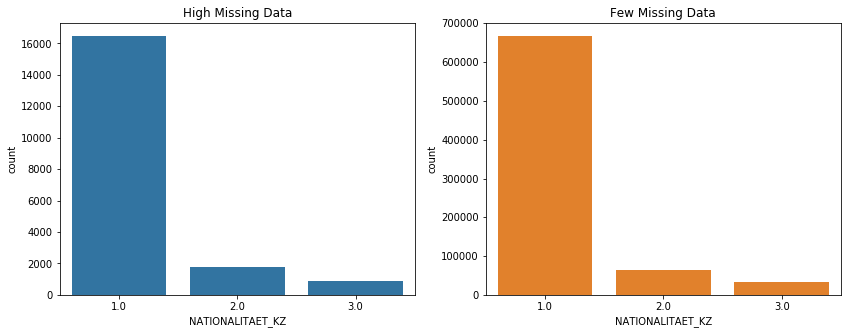

In [21]:
compare('NATIONALITAET_KZ') 

In [12]:
# Drop high missing rows
azdias_few_missing = azdias_missing.copy()
azdias_few_missing = azdias_few_missing.iloc[n_missing_rows_low.index,:]
azdias_few_missing.shape

(797077, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

- Around 10.5% of total number of rows have high missing values according to threshold chosen (>20)
- Dropping these high missing values will cause loss of 10% of data, usually ML models works better with more data, on the
    other hand, it is very difficult to impute many of this missing values as it is related to customers, therefore will make
    inaccurate data which will be much worse than losing these data.
- Data with lots of missing values are qualitatively different from data with few or no missing values since the distribution 
    of the 5 column samples that I take were really different from each other except for 'NATIONALITAET_KZ' which had almost
    same distribution

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [161]:
# How many features are there of each data type?
feat_info_missing.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [13]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_feat = feat_info_missing[feat_info_missing.type == 'categorical']
categorical_feat

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [14]:
binary_integer_columns=[]
binary_columns=[]
multi_level_columns=[]
for category_columns in categorical_feat.attribute.value_counts().index:
    if len(azdias_few_missing[category_columns].value_counts()) > 2:
        multi_level_columns.append(category_columns)
    elif (azdias_few_missing[category_columns].dtype == object):
        binary_columns.append(category_columns)
    else:
        binary_integer_columns.append(category_columns)

In [16]:
binary_integer_columns

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'VERS_TYP', 'SOHO_KZ']

In [17]:
binary_columns

['OST_WEST_KZ']

In [15]:
multi_level_columns

['SHOPPER_TYP',
 'LP_STATUS_FEIN',
 'GFK_URLAUBERTYP',
 'CJT_GESAMTTYP',
 'ZABEOTYP',
 'LP_FAMILIE_FEIN',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'LP_FAMILIE_GROB',
 'NATIONALITAET_KZ',
 'GEBAEUDETYP',
 'LP_STATUS_GROB',
 'FINANZTYP']

In [15]:
for column in binary_integer_columns:
    print(azdias_few_missing[column].value_counts())
print(azdias_few_missing[binary_columns[0]].value_counts())

0.0    790370
1.0      6707
Name: SOHO_KZ, dtype: int64
0    621942
1    175135
Name: GREEN_AVANTGARDE, dtype: int64
2    415578
1    381499
Name: ANREDE_KZ, dtype: int64
2.0    394116
1.0    366623
Name: VERS_TYP, dtype: int64
W    628695
O    168382
Name: OST_WEST_KZ, dtype: int64


In [15]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encode binary columns
azdias_few_missing['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias_few_missing['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias_few_missing['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)


In [16]:
#Test
for column in binary_integer_columns:
    print(azdias_few_missing[column].value_counts())
print(azdias_few_missing[binary_columns[0]].value_counts())

1.0    394116
0.0    366623
Name: VERS_TYP, dtype: int64
1    415578
0    381499
Name: ANREDE_KZ, dtype: int64
0    621942
1    175135
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790370
1.0      6707
Name: SOHO_KZ, dtype: int64
1    628695
0    168382
Name: OST_WEST_KZ, dtype: int64


In [16]:
# Encode the multi-level columns using multiple dummy variables
azdias_few_missing = pd.get_dummies(azdias_few_missing, columns=multi_level_columns)

In [20]:
azdias_few_missing.shape

(797077, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

- Three binary (two-level) categoricals that take numeric values, two of them were re-encoded to (0,1) instead of (1,2)
- One binary variable that takes on non-numeric values which is OST_WEST_KZ was re-encoded using numers(0,1)
- Thirteen multi-level categoricals was encoded using multiple dummy variables
- I choose to not to drop any multi-level from analysis as I feel it will be important in clustering when it comes to using
    unsupervised learning techniques

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [17]:
# Investigation of mixed features
mixed_feat = feat_info_missing[feat_info_missing.type == 'mixed']
mixed_feat

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE", the mapped values is found in Data_Dictionary.md
azdias_few_missing['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182833
8.0     141504
10.0     85746
5.0      84649
3.0      53811
15.0     42500
11.0     35729
9.0      33560
6.0      25649
12.0     24436
1.0      20639
4.0      20450
2.0       7479
13.0      5759
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [ ]:
# Rengineer "PRAEGENDE_JUGENDJAHRE" to two new variables

In [18]:
generation = {0: [1,2],
              1: [3,4],
              2: [5,6,7],
              3: [8,9],
              4: [10,11,12,13],
              5: [14,15]}

avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
mainstream = [1, 3, 5, 8, 10, 12, 14]

def generations(value):
    if (np.isnan(value)):
        return np.nan
    else:
        for key, values in generation.items():
            if (value in values):
                return key

def movement(value):
        if (value in avantgarde):
            return 1
        elif (value in mainstream):
            return 0
        else:
            return np.nan
            


In [19]:
azdias_few_missing['PRAEGENDE_JUGENDJAHRE_GENERATIONS'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE'].apply(generations)
azdias_few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE'].apply(movement)

In [119]:
# Investigate "CAMEO_INTL_2015", the mapped values is found in Data_Dictionary.md
azdias_few_missing['CAMEO_INTL_2015'].dtype

dtype('O')

In [20]:
# Rengineer "CAMEO_INTL_2015" to two new variables
# wealth will be 'tens'-place

def wealth(value):
    # Since "CAMEO_INTL_2015" is an object dtype and NaNs are floats therefore change its type to float for isnan check
    value = float(value) 
    if (np.isnan(value)):
        return np.nan
    else:
        return int(str(value)[0])

#life stage will be 'ones'-place

def life_stage(value):
    value = float(value)
    if (np.isnan(value)):
        return np.nan
    else:
        return int(str(value)[1])
    
        
        
    

In [21]:
azdias_few_missing['CAMEO_INTL_2015_WEALTH'] = azdias_few_missing['CAMEO_INTL_2015'].apply(wealth)
azdias_few_missing['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_few_missing['CAMEO_INTL_2015'].apply(life_stage)

In [127]:
# Pre-check before dropping
azdias_few_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 198 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFE_STAGE
dtypes: float64(46), int64(23), object(1), uint8(128)
memory usage: 529.1+ MB


In [22]:
# Drop all mixed features from our dataset
azdias_few_missing = azdias_few_missing.drop(columns=mixed_feat.attribute.values)

In [132]:
# Check after dropping
azdias_few_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 192 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFE_STAGE
dtypes: float64(41), int64(23), uint8(128)
memory usage: 492.6 MB


#### Discussion 1.2.2: Engineer Mixed-Type Features

- I Re-engineered "PRAEGENDE_JUGENDJAHRE" to two new variables which was generations an interval variable and movements
    a binary variable, as it has provided two informations from one variable only which disobeys what a tidy data should be
    (each column represent one variable) and then dropped this column as it will be useless.
- Same goes for "CAMEO_INTL_2015" it was re-engineered to two new ordinal variables was wealth and life stage and then dropped     this column as it will be useless.
- I choose to drop the rest of the mixed features columns as I felt that provides similar informations such as other columns
    and to make use of these messy columns will require more understanding of these columns and reengineering which will
    unnecessary waste of time. A more precise check can be made, which is to check correlation of these mixed features with 
    other features to see whether they provide new or similar information (won't do this check for the sake of time).
    

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [134]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_few_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 192 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFE_STAGE
dtypes: float64(41), int64(23), uint8(128)
memory usage: 492.6 MB


In [137]:
azdias_few_missing.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,PRAEGENDE_JUGENDJAHRE_GENERATIONS,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,1,0,0,5.0,0.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,1,0,0,0,0,5.0,1.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,3.0,0.0,1.0,2.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [23]:
def clean_data(azdias, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    azdias_missing = azdias
    # Identify missing or unknown data values and convert them to NaNs.
    for i in range(feat_info.shape[0]):
        missing = feat_info.missing_or_unknown.iloc[i]
        attribute_column_name = feat_info.attribute.iloc[i]
        missing = missing[1:-1]
        if(len(missing) == 0):
            azdias_missing[attribute_column_name] = azdias_missing[attribute_column_name].replace(missing,np.nan)
        elif(len(missing) != 0):
            missing = missing.split(',')
            for j in range(len(missing)):
                if(azdias_missing[attribute_column_name].dtype == np.float64):
                    azdias_missing[attribute_column_name] = azdias_missing[attribute_column_name].replace(float(missing[j]),np.nan)
                elif(azdias_missing[attribute_column_name].dtype == np.int64):
                    azdias_missing[attribute_column_name] = azdias_missing[attribute_column_name].replace(int(missing[j]),np.nan)
                
                else:
                    azdias_missing[attribute_column_name] = azdias_missing[attribute_column_name].replace(missing[j],np.nan)
    
    # Analyzed outlier columns with most missing values
    outlier_columns = ['AGER_TYP', 'KK_KUNDENTYP','TITEL_KZ', 'KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    azdias_missing = azdias_missing.drop(outlier_columns, axis=1)
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.
    n_missing_rows = azdias_missing.isna().sum(axis=1)
    n_missing_rows_high = n_missing_rows[n_missing_rows > 20]
    n_missing_rows_low = n_missing_rows[n_missing_rows < 20]
    
    # Drop high missing rows
    azdias_few_missing = azdias_missing.copy()
    azdias_few_missing = azdias_few_missing.iloc[n_missing_rows_low.index,:]
    feat_info_missing = feat_info
    feat_info_missing = feat_info_missing[~feat_info_missing.attribute.isin(outlier_columns)]
    
    # Identify binary and multi-level columns
    categorical_feat = feat_info_missing[feat_info_missing.type == 'categorical']
    binary_integer_columns=[]
    binary_columns=[]
    multi_level_columns=[]
    for category_columns in categorical_feat.attribute.value_counts().index:
        if len(azdias_few_missing[category_columns].value_counts()) > 2:
            multi_level_columns.append(category_columns)
        elif (azdias_few_missing[category_columns].dtype == object):
            binary_columns.append(category_columns)
        else:
            binary_integer_columns.append(category_columns)
    
    # Re-encode binary columns
    azdias_few_missing['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    azdias_few_missing['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    azdias_few_missing['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
    # Encode the multi-level columns using multiple dummy variables
    azdias_few_missing = pd.get_dummies(azdias_few_missing, columns=multi_level_columns)
    
    # Rengineer "PRAEGENDE_JUGENDJAHRE" to two new variables
    azdias_few_missing['PRAEGENDE_JUGENDJAHRE_GENERATIONS'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE'].apply(generations)
    azdias_few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    
    # Rengineer "CAMEO_INTL_2015" to two new variables
    azdias_few_missing['CAMEO_INTL_2015_WEALTH'] = azdias_few_missing['CAMEO_INTL_2015'].apply(wealth)
    azdias_few_missing['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_few_missing['CAMEO_INTL_2015'].apply(life_stage)
    
    # Drop all mixed features from our dataset
    mixed_feat = feat_info_missing[feat_info_missing.type == 'mixed']
    azdias_few_missing = azdias_few_missing.drop(columns=mixed_feat.attribute.values)

    return azdias_few_missing

In [37]:
# Test clean_data function
azdias_using_clean_function = clean_data(azdias, feat_info)
azdias_using_clean_function.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 192 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFE_STAGE
dtypes: float64(41), int64(23), uint8(128)
memory usage: 492.6 MB


In [38]:
# Check if azdias_few_missing that I Cleaned before is exactly equal to the one output from clean_data function
azdias_few_missing.equals(azdias_using_clean_function)

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [152]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_few_missing.isna().any().values

array([ True, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [24]:
fill_nan = Imputer(missing_values=np.nan, strategy='mean', axis=1)
azdias_cleaned = pd.DataFrame(fill_nan.fit_transform(azdias_few_missing), columns=azdias_few_missing.keys())
azdias_cleaned.isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [25]:
# Dropping column=GEBAEUDETYP_6.0 as this appered in azdias data after one hot encoding
# and didn't appear in customers data after one hot encoding which caused dimension problems 
# in step 3.2 and also it will not be an important feature if it appeared in azdias only.
azdias_cleaned.drop(columns=['GEBAEUDETYP_6.0'], inplace=True)
azdias_cleaned.shape[1]

191

In [27]:
# Check mean and std before applying standard scaler
azdias_cleaned.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,PRAEGENDE_JUGENDJAHRE_GENERATIONS,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
count,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,...,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000
mean,2.837586,0.521377,3.058727,2.715815,3.432951,2.840685,2.656884,3.115607,0.219722,2.777840,...,0.116917,0.177105,0.184509,0.248519,0.139299,0.127840,3.741627,0.747843,3.339084,2.952247
std,1.248993,0.499543,1.377570,1.485032,1.376959,1.472527,1.399118,1.407806,0.414058,2.773639,...,0.321322,0.381757,0.387899,0.432155,0.346258,0.333911,2.593454,2.762380,1.715348,1.749939
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.000000
50%,3.000000,1.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,4.000000,3.000000
75%,4.000000,1.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,5.000000,4.000000
max,23.137566,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,24.549451,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.915730,24.915730,23.684211,23.684211


In [26]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns=azdias_cleaned.keys())

In [29]:
# Check if new mean equals 0 and std equals 1
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,PRAEGENDE_JUGENDJAHRE_GENERATIONS,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
count,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,...,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05
mean,-1.429863e-16,8.441894e-17,-1.709506e-16,-7.889204e-18,1.460974e-16,7.380195e-17,-1.123387e-16,-6.234700e-17,-4.245462e-17,-3.621056e-16,...,-2.050302e-17,4.028174e-17,-6.949631e-17,1.943329e-18,-2.165743e-17,-5.127983e-17,-3.062616e-16,-1.082069e-16,8.961779e-16,-2.120190e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.471255e+00,-1.043709e+00,-1.494463e+00,-1.155407e+00,-1.766903e+00,-1.250019e+00,-1.184235e+00,-1.502770e+00,-5.306541e-01,-6.409776e-01,...,-3.638635e-01,-4.639195e-01,-4.756630e-01,-5.750705e-01,-4.022979e-01,-3.828552e-01,-1.442721e+00,-2.707242e-01,-1.363621e+00,-1.115610e+00
25%,-6.706096e-01,-1.043709e+00,-7.685472e-01,-1.155407e+00,-1.040664e+00,-1.250019e+00,-1.184235e+00,-7.924445e-01,-5.306541e-01,-2.804402e-01,...,-3.638635e-01,-4.639195e-01,-4.756630e-01,-5.750705e-01,-4.022979e-01,-3.828552e-01,-6.715478e-01,-2.707242e-01,-7.806491e-01,-1.115610e+00
50%,1.300356e-01,9.581212e-01,-4.263094e-02,1.913661e-01,4.118132e-01,1.081913e-01,-4.694988e-01,-8.211890e-02,-5.306541e-01,-2.804402e-01,...,-3.638635e-01,-4.639195e-01,-4.756630e-01,-5.750705e-01,-4.022979e-01,-3.828552e-01,9.962496e-02,-2.707242e-01,3.852955e-01,2.728827e-02
75%,9.306809e-01,9.581212e-01,6.832853e-01,8.647525e-01,1.138052e+00,7.872963e-01,9.599741e-01,6.282067e-01,-5.306541e-01,8.009715e-02,...,-3.638635e-01,-4.639195e-01,-4.756630e-01,-5.750705e-01,-4.022979e-01,-3.828552e-01,4.852113e-01,9.128273e-02,9.682678e-01,5.987372e-01
max,1.625308e+01,9.581212e-01,1.409202e+00,1.538139e+00,1.138052e+00,1.466401e+00,1.674710e+00,1.338532e+00,1.884467e+00,7.849480e+00,...,2.748284e+00,2.155547e+00,2.102329e+00,1.738917e+00,2.485720e+00,2.611954e+00,8.164446e+00,8.748943e+00,1.186065e+01,1.184726e+01


### Discussion 2.1: Apply Feature Scaling

- I have chose to impute missing values with mean of its column values as the mean takes all data into account and
    it is the best strategy to make an infrence of the missing values

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [32]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)


In [30]:
# Using Udacity's class helper method for plotting explained_variance_ratio_
def scree_plot(pca, num_components=None):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    if (num_components == None):
        num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_[:num_components]
 
    plt.figure(figsize=(18, 12))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

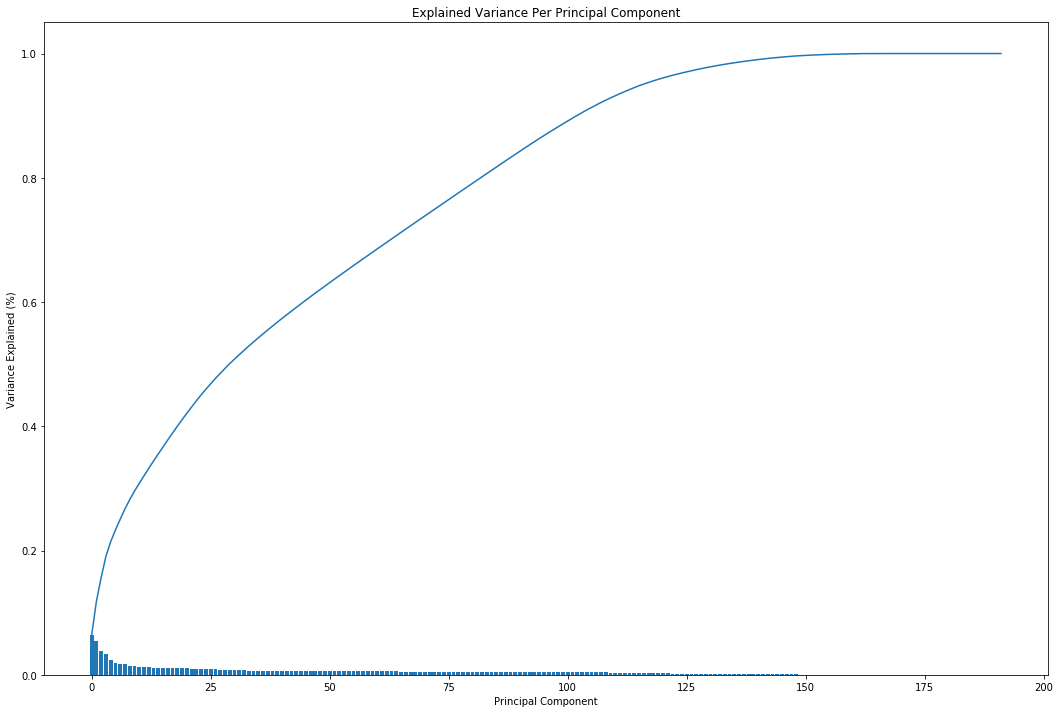

In [54]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [83]:
# How much variance in the original data is explained when increasing number of components
for i in np.arange(10, len(pca.explained_variance_ratio_), 20):
    print('{} components explains {}% of variance'.format(i,(pca.explained_variance_ratio_[:i].sum()) * 100))

10 components explains 29.565610491284527% of variance
30 components explains 50.087056089276686% of variance
50 components explains 62.570974907754064% of variance
70 components explains 73.33881195472105% of variance
90 components explains 83.7863689987286% of variance
110 components explains 92.8634353729513% of variance
130 components explains 97.7208102605025% of variance
150 components explains 99.66441850193422% of variance
170 components explains 99.99999999999997% of variance
190 components explains 100.0% of variance


In [27]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=103)
azdias_pca = pca.fit_transform(azdias_scaled)


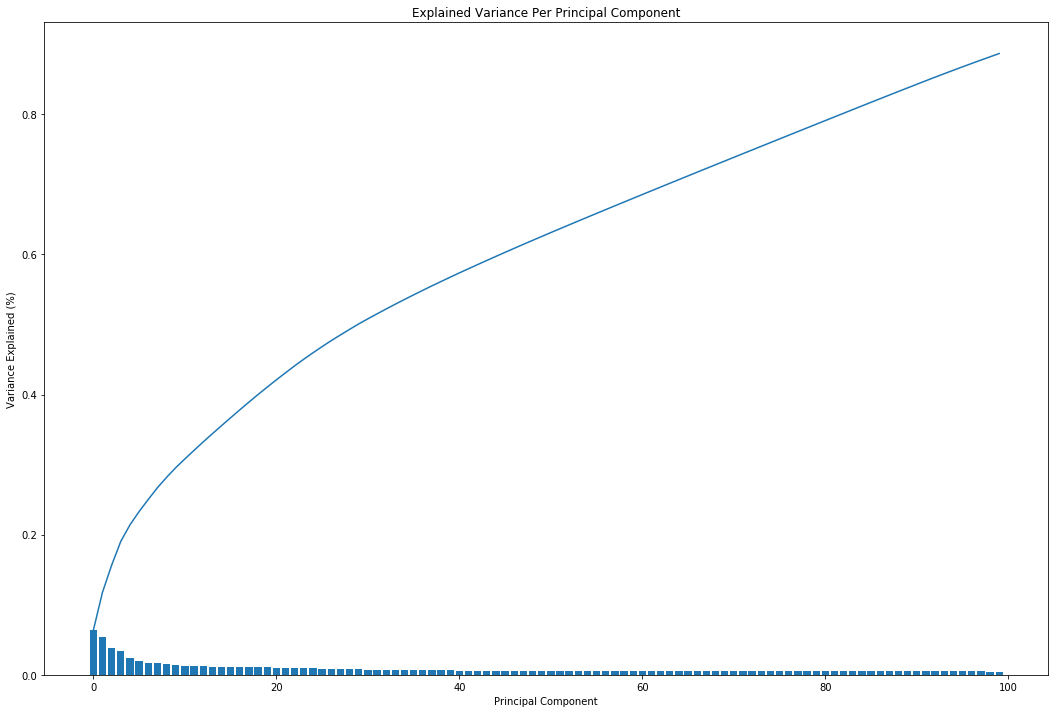

In [90]:
# Zooming in for the chosen 103 comonents
scree_plot(pca,num_components=103)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

- It is found that variance explained in the original data by 130 features out of 192 equals 97% which means that removing 62 
    features will only result in only 3% loss of information and that is fascinating
- I chose to retain 103 principal components which will explain exactly 90% of total variance in the original data which I
    believe is very small amount of information lost, therefore will be good for the accuracy of unsupervised model


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [28]:
def pca_results(df, pca, component_no, features_no):
    '''
    Create a DataFrame of the PCA results
    Visualizes the PCA results for a speacific component number for a speacific number of features
    '''
    
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    # Capturing most interesting features which at the end and beginning of sorted list
    pca_comp = pd.concat([pca_comp.head(features_no), pca_comp.tail(features_no)])
    
    pca_comp.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(features_no*2, component_no),
                  figsize=(12, 6));
    plt.show()
    
    return pca_comp

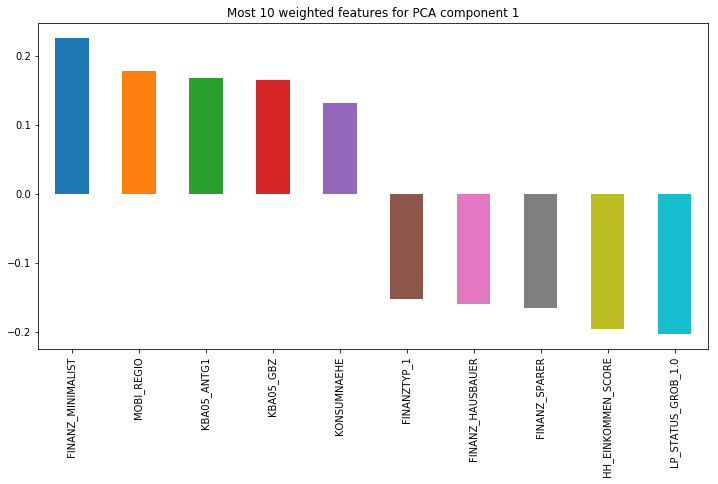

FINANZ_MINIMALIST     0.2266
MOBI_REGIO            0.1787
KBA05_ANTG1           0.1676
KBA05_GBZ             0.1656
KONSUMNAEHE           0.1310
FINANZTYP_1          -0.1531
FINANZ_HAUSBAUER     -0.1602
FINANZ_SPARER        -0.1659
HH_EINKOMMEN_SCORE   -0.1957
LP_STATUS_GROB_1.0   -0.2035
Name: 0, dtype: float64

In [62]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_scaled, pca, 1, 5)

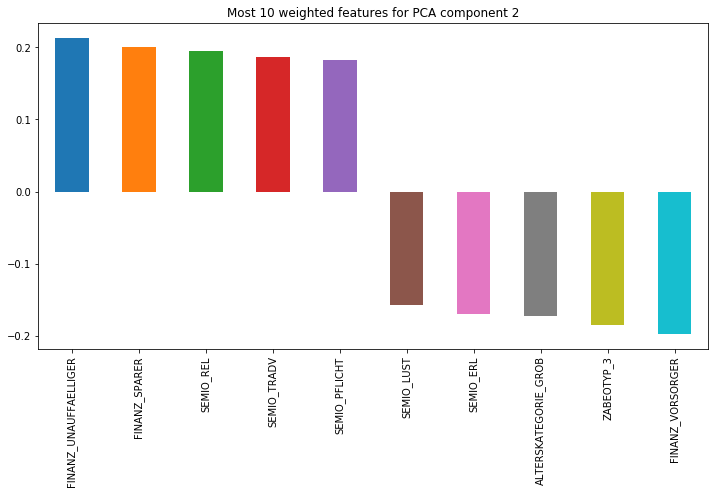

FINANZ_UNAUFFAELLIGER    0.2132
FINANZ_SPARER            0.2006
SEMIO_REL                0.1952
SEMIO_TRADV              0.1869
SEMIO_PFLICHT            0.1824
SEMIO_LUST              -0.1573
SEMIO_ERL               -0.1691
ALTERSKATEGORIE_GROB    -0.1722
ZABEOTYP_3              -0.1843
FINANZ_VORSORGER        -0.1973
Name: 1, dtype: float64

In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_scaled, pca, 2, 5)

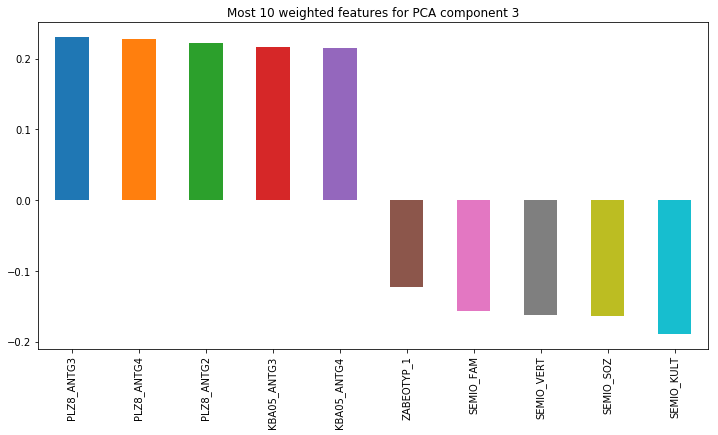

PLZ8_ANTG3     0.2301
PLZ8_ANTG4     0.2279
PLZ8_ANTG2     0.2217
KBA05_ANTG3    0.2159
KBA05_ANTG4    0.2148
ZABEOTYP_1    -0.1236
SEMIO_FAM     -0.1573
SEMIO_VERT    -0.1629
SEMIO_SOZ     -0.1636
SEMIO_KULT    -0.1890
Name: 2, dtype: float64

In [66]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_scaled, pca, 3, 5)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)
- Most weighted features for the first principle component             
    -FINANZ_MINIMALIST: Financial typology, for low financial interest   
    -MOBI_REGIO: Movement patterns       
    -KBA05_ANTG1: Number of 1-2 family houses in the microcell     
    -KBA05_GBZ: Number of buildings in the microcell        
    -KONSUMNAEHE: Distance from building to point of sale (PoS)     
    -FINANZTYP_1:       
    -FINANZ_HAUSBAUER: Financial typology, home ownership    
    -FINANZ_SPARER: Financial typology, for money-saver       
    -HH_EINKOMMEN_SCORE: Estimated household net income


- Most weighted features for the Second principle component                        
    -FINANZ_UNAUFFAELLIGER: Financial typology, for inconspicuous   
    -FINANZ_SPARER: Financial typology, for money-saver           
    -SEMIO_REL: Personality typology, for religious  
    -SEMIO_TRADV: Personality typology, for tradional-minded  
    -SEMIO_PFLICHT: Personality typology, for dutiful   
    -SEMIO_LUST: Personality typology, for sensual-minded          
    -SEMIO_ERL: Personality typology, for event-oriented          
    -ALTERSKATEGORIE_GROB: Estimated age based on given name analysis  
    -ZABEOTYP_3:           
    -FINANZ_VORSORGER: Financial typology, be prepared


- Most weighted features for the third principle component                    
    -PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region                   
    -PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region          
    -PLZ8_ANTG2: Number of 3-5 family houses in the PLZ8 region  
    -KBA05_ANTG3: Number of 6-10 family houses in the microcell  
    -KBA05_ANTG4: Number of 10+ family houses in the microcell   
    -ZABEOTYP_1:   
    -SEMIO_FAM: Personality typology, for family-minded  
    -SEMIO_VERT: Personality typology, for dreamful   
    -SEMIO_SOZ: Personality typology, for socially-minded   
    -SEMIO_KULT: Personality typology, for cultural-minded  
 
 
- From above mapping we can deduce that:
    - First Principle component positively weights items related to people with low financial interest and movement patterns
        and negatively weights items related to people with financial typology money savers and home ownership. 
    
    - Second Principle component positively weights items related to people with inconspicuous and money-saver financial   
        topology. Also, items related to religious, tradional-minded and dutiful personality. Moreover, negatively weights
        weights items related to people with be prepared financial typology and estimated age.
    
    - Third Principle component positively weights items related to Number of family houses in the PLZ8 region and negatively         weights items related to people with cultural-minded, socially-minded and dreamful personality typology.
    - Also it is noted that positive weights items are correlated together and the same goes for negatively weighted
        items.
    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [29]:
# Using Udacity k-means classroom as a refrence to the below function
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    # Will make max_inter = 20 instead of default 300 as it takes very long time to run
    kmeans = KMeans(n_clusters=center, max_iter=20) 

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [34]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

scores = []
centers = np.arange(1,30,2)

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))

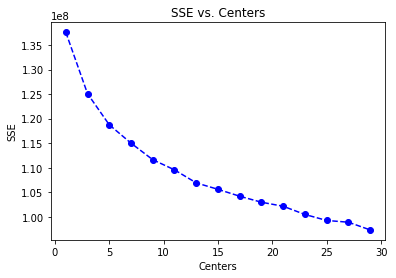

In [35]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Centers');
plt.ylabel('SSE');
plt.title('SSE vs. Centers');

In [30]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k = 23
kmeans = KMeans(n_clusters=k)
model = kmeans.fit(azdias_pca)
azdias_clustered = model.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

- By using elbow method we can see a strong leveling off after 23 clusters, which suggests 23 clusters should be used

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [33]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', ';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [35]:
# Preprocessing
customers_cleaned = clean_data(customers, feat_info)

In [75]:
customers_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141590 entries, 0 to 191651
Columns: 191 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFE_STAGE
dtypes: float64(41), int64(23), uint8(127)
memory usage: 87.4 MB


In [43]:
# This is the only column that is in azdias and not found in customers data after one hot encoding
# This was toubleshooting and this column is dropped in the cell before scaling azdias
# And it will be logical as the 2 below cells shows that counts for 6.0 is 4 times highers in azdias data
# which make it possibly dropped in the rows by using the threshold set in clean data
azdias_few_missing['GEBAEUDETYP_6.0'].isin(customers_cleaned.columns).sum()

0

In [34]:
customers['GEBAEUDETYP'].value_counts()

1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
Name: GEBAEUDETYP, dtype: int64

In [32]:
azdias['GEBAEUDETYP'].value_counts()

1.0    460465
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: int64

In [45]:
# Check missing values
customers_cleaned.isna().any().sum()

34

In [45]:
# Remove rows with NaNs
customers_cleaned = customers_cleaned.dropna()

In [61]:
# Check missing values
customers_cleaned.isna().any().sum()

0

In [46]:
# Standardizing data
customers_scaled = scaler.transform(customers_cleaned)

In [47]:
# Applying PCA
customers_pca = pca.transform(customers_scaled)

In [48]:
# Cluster predictions for customer data 
customers_clustered = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [49]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_prop = []
customers_prop = []
clusters = np.arange(0, k+1)

for cluster in clusters:
    general_prop.append((azdias_clustered == cluster).sum() / len(azdias_clustered))
    customers_prop.append((customers_clustered == cluster).sum() / len(customers_clustered))

general_prop = pd.Series(general_prop)
customers_prop = pd.Series(customers_prop)
clusters = pd.Series(clusters)

proportions = pd.concat([clusters, general_prop, customers_prop],axis=1)
proportions.columns = ['clusters', 'general_prop', 'customers_prop']
proportions.head()


,clusters,general_prop,customers_prop
0,0,0.013168,0.003208
1,1,0.031726,0.003251
2,2,0.040292,0.036474
3,3,0.070454,0.243102
4,4,0.056313,0.127427


In [50]:
# Getting prop of high missing values that exceeded threshold
azdias_high_missing_prop = len(n_missing_rows_high) / azdias.shape[0]
customer_high_missing_prop = (customers.shape[0] - customers_cleaned.shape[0]) / customers.shape[0]

In [51]:
# Adding missing rows prop to proportions dataframe
proportions = proportions.append({'clusters': -1 , 'general_prop': azdias_high_missing_prop,
                                'customers_prop': customer_high_missing_prop} ,
                                ignore_index=True)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

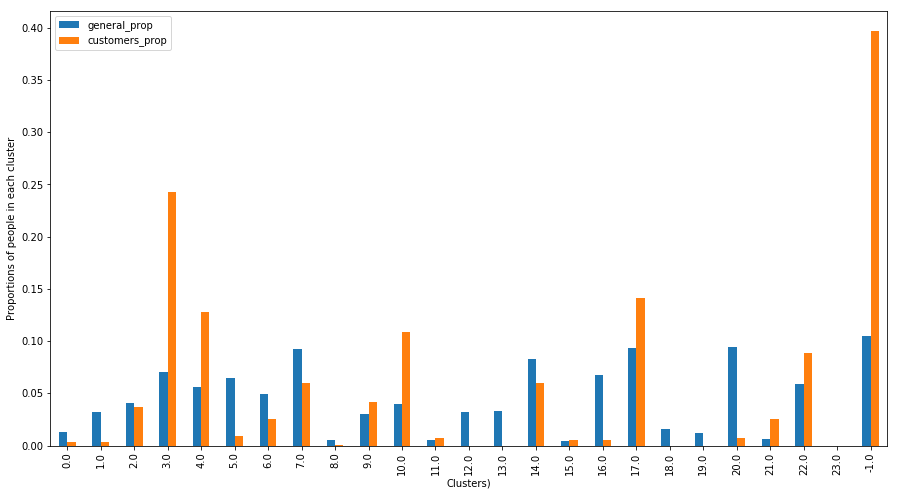

In [52]:
proportions.plot(x='clusters', y = ['general_prop', 'customers_prop'], kind='bar', figsize=(15,8));
plt.xlabel('Clusters)')
plt.ylabel('Proportions of people in each cluster')
plt.xticks(rotation=90)


In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 3 is an example of overrepresentation 

In [53]:

centroid_cluster_3 = pd.Series(kmeans.cluster_centers_[3]).sort_values(ascending=False)
centroid_cluster_3.head(2)

0    3.403475
4    2.552964
dtype: float64

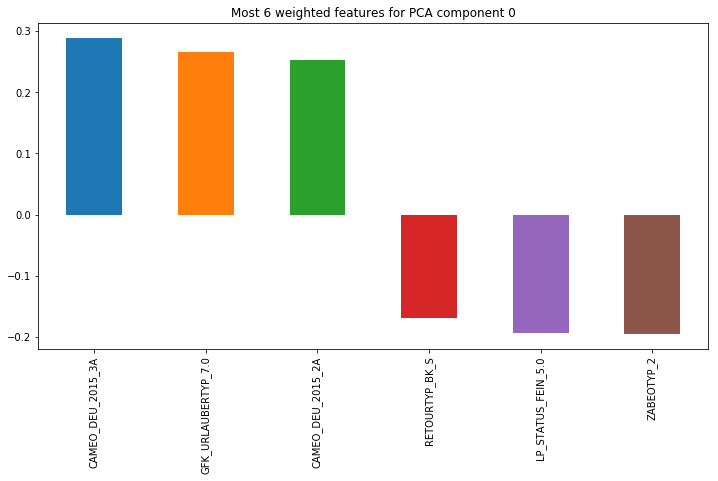

CAMEO_DEU_2015_3A      0.2892
GFK_URLAUBERTYP_7.0    0.2653
CAMEO_DEU_2015_2A      0.2518
RETOURTYP_BK_S        -0.1687
LP_STATUS_FEIN_5.0    -0.1930
ZABEOTYP_2            -0.1954
Name: 102, dtype: float64

In [54]:
# Analysing most weigthed features for the top principal component of centroid_cluster_20
pca_results(customers_cleaned, pca, 0, 3)

#### Observation for PC#0

-CAMEO_DEU_2015_3A: Career & Family   
-GFK_URLAUBERTYP_7.0: Golden ager vacation habits   
-CAMEO_DEU_2015_2A: Cottage Chic   
-RETOURTYP_BK_S:  Return type      
-LP_STATUS_FEIN_5.0: minimalistic high-income earners social status  
-ZABEOTYP_2: Smart Energy consumption      

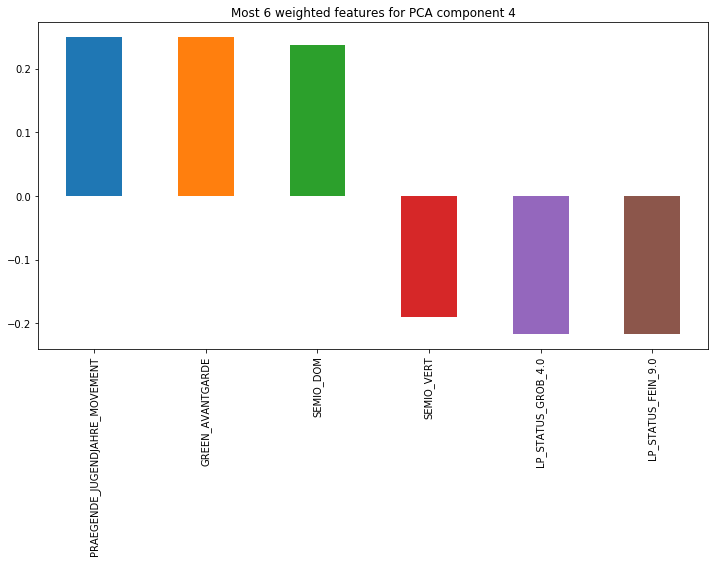

PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.2492
GREEN_AVANTGARDE                  0.2492
SEMIO_DOM                         0.2376
SEMIO_VERT                       -0.1897
LP_STATUS_GROB_4.0               -0.2162
LP_STATUS_FEIN_9.0               -0.2163
Name: 3, dtype: float64

In [74]:
pca_results(customers_cleaned, pca, 4, 3)

#### Observation for PC#4

-PRAEGENDE_JUGENDJAHRE_MOVEMENT: Avantgarde vs. Mainsteram  
-GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth              
-SEMIO_DOM: Dominant-minded                  
-SEMIO_VERT: Dreamful                   
-LP_STATUS_GROB_4.0: Houseowners on social status, rough scale          
-LP_STATUS_FEIN_9.0: Houseowners on social status, fine scale         

In [81]:
# Transforming centroids of cluster 3 back to the original data space

centroid_cluster_3 = scaler.inverse_transform(pca.inverse_transform(centroid_cluster_3))
centroid_cluster_3 = pd.Series(centroid_cluster_3).round()
centroid_cluster_3.index = customers_cleaned.columns

In [80]:
# Printing original values of the most featured weight of principal components to have an insight
print('PRAEGENDE_JUGENDJAHRE_MOVEMENT: Avantgarde vs. Mainsteram  {}'.format(centroid_cluster_3['PRAEGENDE_JUGENDJAHRE_MOVEMENT']))
print('GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth {}'.format(centroid_cluster_3['GREEN_AVANTGARDE']))
print('SEMIO_DOM: Dominant-minded {}'.format(centroid_cluster_3['SEMIO_DOM']))
print('SEMIO_VERT: Dreamful {}'.format(centroid_cluster_3['SEMIO_VERT']))
print('LP_STATUS_GROB_4.0: Houseowners on social status, rough scale {}'.format(centroid_cluster_3['LP_STATUS_GROB_4.0']))
print('LP_STATUS_FEIN_9.0: Houseowners on social status, fine scale {}'.format(centroid_cluster_3['LP_STATUS_FEIN_9.0']))
print('CAMEO_DEU_2015_3A: Career & Family {}'.format(centroid_cluster_3['CAMEO_DEU_2015_3A']))
print('GFK_URLAUBERTYP_7.0: Golden ager vacation habits {}'.format(centroid_cluster_3['GFK_URLAUBERTYP_7.0']))
print('CAMEO_DEU_2015_2A: Cottage Chic {}'.format(centroid_cluster_3['CAMEO_DEU_2015_2A']))
print('RETOURTYP_BK_S:  Return type {}'.format(centroid_cluster_3['RETOURTYP_BK_S']))
print('LP_STATUS_FEIN_5.0: minimalistic high-income earners social status {}'.format(centroid_cluster_3['LP_STATUS_FEIN_5.0']))
print('ZABEOTYP_2: Smart Energy consumption {}'.format(centroid_cluster_3['ZABEOTYP_2']))

PRAEGENDE_JUGENDJAHRE_MOVEMENT: Avantgarde vs. Mainsteram  1.0
GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth 0.0
SEMIO_DOM: Dominant-minded 4.0
SEMIO_VERT: Dreamful 5.0
LP_STATUS_GROB_4.0: Houseowners on social status, rough scale 0.0
LP_STATUS_FEIN_9.0: Houseowners on social status, fine scale 0.0
CAMEO_DEU_2015_3A: Career & Family -0.0
GFK_URLAUBERTYP_7.0: Golden ager vacation habits -0.0
CAMEO_DEU_2015_2A: Cottage Chic -0.0
RETOURTYP_BK_S:  Return type 3.0
LP_STATUS_FEIN_5.0: minimalistic high-income earners social status 0.0
ZABEOTYP_2: Smart Energy consumption 0.0


In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 20 is an example of underrepresentation 

In [62]:
centroid_cluster_20 = pd.Series(kmeans.cluster_centers_[20]).sort_values(ascending=False)
centroid_cluster_20.head(2)

1    1.616102
2    1.106325
dtype: float64

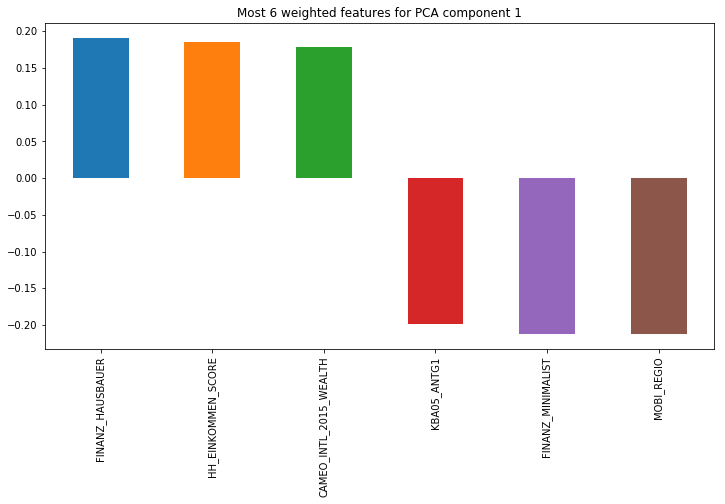

FINANZ_HAUSBAUER          0.1910
HH_EINKOMMEN_SCORE        0.1848
CAMEO_INTL_2015_WEALTH    0.1782
KBA05_ANTG1              -0.1983
FINANZ_MINIMALIST        -0.2116
MOBI_REGIO               -0.2127
Name: 0, dtype: float64

In [75]:
# Analysing most weigthed features for the top principal component of centroid_cluster_15
pca_results(customers_cleaned, pca, 1, 3)

#### Observation for PC#1

-FINANZ_HAUSBAUER: Home ownership on financial topology  
-HH_EINKOMMEN_SCORE: Estimated household net income       
-CAMEO_INTL_2015_WEALTH: Wealth   
-KBA05_ANTG1: Number of 1-2 family houses in the microcell            
-FINANZ_MINIMALIST: Low financial interest         
-MOBI_REGIO: Movement patterns 

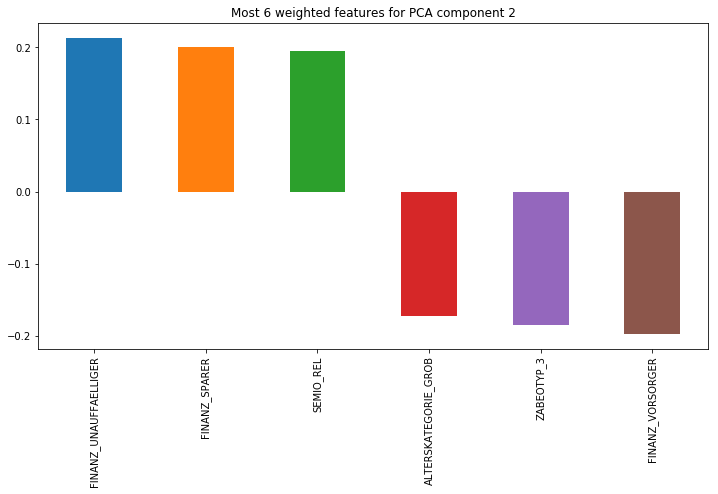

FINANZ_UNAUFFAELLIGER    0.2132
FINANZ_SPARER            0.2006
SEMIO_REL                0.1952
ALTERSKATEGORIE_GROB    -0.1722
ZABEOTYP_3              -0.1843
FINANZ_VORSORGER        -0.1973
Name: 1, dtype: float64

In [63]:
# Analysing most weigthed features for the top principal component of centroid_cluster_15
pca_results(customers_cleaned, pca, 2, 3)

#### Observation for PC#2

-FINANZ_UNAUFFAELLIGER: inconspicuous                  
-FINANZ_SPARER:  Money-saver    
-SEMIO_REL: Religious personality                     
-ALTERSKATEGORIE_GROB: Estimated age based on given name analysis 
-ZABEOTYP_3: Fair supplied energy consumption typology           
-FINANZ_VORSORGER: Financial topology of be prepared         

In [76]:
# Transforming centroids back to the original data space
centroid_cluster_20 = scaler.inverse_transform(pca.inverse_transform(centroid_cluster_20))
centroid_cluster_20 = pd.Series(centroid_cluster_20).round()
centroid_cluster_20.index = customers_cleaned.columns

In [79]:
# Printing original values of the most featured weight of principal components to have an insight
print('FINANZ_UNAUFFAELLIGER: inconspicuous {}'.format(centroid_cluster_20['FINANZ_UNAUFFAELLIGER']))
print('FINANZ_SPARER:  Money-saver {}'.format(centroid_cluster_20['FINANZ_SPARER']))
print('SEMIO_REL: Religious personality {}'.format(centroid_cluster_20['SEMIO_REL']))
print('ALTERSKATEGORIE_GROB: Estimated age based on given name analysis  {}'.format(centroid_cluster_20['ALTERSKATEGORIE_GROB']))
print('ZABEOTYP_3: Fair supplied energy consumption typology {}'.format(centroid_cluster_20['ZABEOTYP_3']))
print('FINANZ_VORSORGER: Financial topology of be prepared {}'.format(centroid_cluster_20['FINANZ_VORSORGER']))
print('FINANZ_HAUSBAUER: Home ownership on financial topology {}'.format(centroid_cluster_20['FINANZ_HAUSBAUER']))
print('HH_EINKOMMEN_SCORE: Estimated household net income {}'.format(centroid_cluster_20['HH_EINKOMMEN_SCORE']))
print('CAMEO_INTL_2015_WEALTH: Wealth {}'.format(centroid_cluster_20['CAMEO_INTL_2015_WEALTH']))
print('KBA05_ANTG1: Number of 1-2 family houses in the microcell {}'.format(centroid_cluster_20['KBA05_ANTG1']))
print('FINANZ_MINIMALIST: Low financial interest {}'.format(centroid_cluster_20['FINANZ_MINIMALIST']))
print('MOBI_REGIO: Movement patterns {}'.format(centroid_cluster_20['MOBI_REGIO']))

FINANZ_UNAUFFAELLIGER: inconspicuous 3.0
FINANZ_SPARER:  Money-saver 3.0
SEMIO_REL: Religious personality 4.0
ALTERSKATEGORIE_GROB: Estimated age based on given name analysis  3.0
ZABEOTYP_3: Fair supplied energy consumption typology 0.0
FINANZ_VORSORGER: Financial topology of be prepared 3.0
FINANZ_HAUSBAUER: Home ownership on financial topology 3.0
HH_EINKOMMEN_SCORE: Estimated household net income 4.0
CAMEO_INTL_2015_WEALTH: Wealth 4.0
KBA05_ANTG1: Number of 1-2 family houses in the microcell 3.0
FINANZ_MINIMALIST: Low financial interest 4.0
MOBI_REGIO: Movement patterns 5.0


### Discussion 3.3: Compare Customer Data to Demographics Data



#### Attributes of the original data of the population that are relatively popular with the mail-order company 

Avantgarde, not a member of green avantgarde, average affinity dominant-minded, low affinity dreamful, not a houseowners, do not have career and family neither cottage chic life stage typology, not a golden ager vacation habits, incentive-receptive normal-returner, not a minimalistic high-income earners social status and not a smart energy consumption

#### Attributes of the population that are relatively unpopular with the mail-order company
Average inconspicuous financial, money-saver, home ownership and be prepared, average affinity religious personality, age ranges between 46 - 60 years old, not a fair supplied energy consumer, average estimated household net income, Less affluent households, high share of 1-2 family homes, Low financial interest and a very low movement patterns

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.